In [170]:
import numpy as np
import random as r


def relu(array):
    return np.maximum(0, array)

class Layer_Dense:
    def __init__(self, d_inputs, n_neurons, n_inputs):
        self.d_inputs = d_inputs
        self.n_neurons = n_neurons
        self.n_inputs = n_inputs
        self.weights = np.empty((n_neurons, d_inputs))
        self.biases = np.empty((n_neurons, n_inputs))

    def forward(self, inputs):
        self.output= np.dot(self.weights, inputs) + self.biases

    def attrib_r(self):
      self.weights = 0.10 * np.random.randn(self.n_neurons, self.d_inputs)
      self.biases = np.tile(0.1 * np.random.randn(1, self.n_neurons).reshape(-1, 1), (1, self.n_inputs))

    def mut(self, p, cr):

        Lay = Layer_Dense(self.d_inputs, self.n_neurons, self.n_inputs)

        Lay.weights = self.weights.copy()
        Lay.biases = self.biases.copy()

        n_weights = self.n_neurons*self.d_inputs
        num_w_mod = int(n_weights * p)

        if num_w_mod > 0:
            indices = np.unravel_index(np.random.choice(n_weights, num_w_mod, replace=False), (self.n_neurons, self.d_inputs))
            changes_w = np.random.uniform(-cr, cr, num_w_mod)
            Lay.weights[indices] += changes_w

        n_b = self.n_neurons
        num_b_mod = int(n_b*p)+ (1 if r.random() < 0.5 else 0)

        if num_b_mod > 0:
            indices_b = np.unravel_index(np.random.choice(n_b, num_b_mod, replace=False), (n_b, 1))
            changes_b = np.random.uniform(-cr, cr, num_b_mod)
            Lay.biases[indices_b] += changes_b
        
        return(Lay)
    
class NeuralN:
    def  __init__(self, l):
        self.l = l
        self.wl = []

    def process(self, input):
        output = input
        for layers in self.l:
            layers.forward(output)
            output = layers.output
        return output.T

    def mutNN(self, p, cr):
        return NeuralN([layers.mut(p, cr) for layers in self.l])
    
    def attribNN_r(self):
        for layers in self.l:
            layers.attrib_r()
        
    def wl_update(self):#Pour manipuler plus facilement les poids
        self.wl= []
        for r in self.l:
            n , d = r.n_neurons, r.d_inputs
            for i in range(n):
                for k in range(d): #weights
                    self.wl.append(r.weights[i][k])
            for i in range(n): #biases
                self.wl.append(r.biases[i][0])
    
class Opti:
    def __init__(self, fonc, NN, grad, loss):
        self.f = fonc
        self.NN = NN
        self.grad = grad
        self.gl = []
        self.loss = loss
        t = 0
        for r in NN.l:
            t += (r.n_neurons*(r.d_inputs+1))
        self.v = np.zeros((t, fonc.vl))

    
    def gr_update(self):
        self.gl = self.grad(self.NN.wl)

    
    def update(self):
        self.gr_update()
        j = 0
        for r in self.NN.l:
            n , d = r.n_neurons, r.d_inputs
            for i in range(n):
                for k in range(d): #weights
                    (r.weights[i][k], self.v[(i*d)+k+j]) = self.f.mod(r.weights[i][k], self.gl[(i*d)+k+j], self.v[(i*d)+k+j])
            j+=n*d
            for i in range(n): #biases
                (r.biases[i], self.v[i+j]) = self.f.mod(r.biases[i][0], self.gl[i+j], self.v[i+j])
            j += n


    def train(self, nb_epoch):
        losslst, poidslst = [], []
        for epoch in range(nb_epoch):
            self.NN.wl_update()
            losslst.append(self.loss(self.NN.wl))
            poidslst.append(self.NN.wl)
            self.update()
        return (losslst, poidslst)
    
    def train2(self, nb_epoch):
        losslst = []
        for epoch in range(nb_epoch):
            self.NN.wl_update()
            losslst.append(self.loss(self.NN.wl))
            self.update()
        return losslst



class Algos:
    def __init__(self, algo, param, vlen):
        self.a = algo
        self.p = param
        self.vl = vlen

    def mod(self, w, g, vlst):
        return self.a(w, g, self.p, vlst)
    

In [311]:
from matplotlib import pyplot as p

class Visu:
    def __init__(self, NNi, fctgr, perte, l_algos, n, start):
        self.l_algos = l_algos
        self.n = n
        if start == []:
            NNi.attribNN_r()
        else:
            j = 0
            for r in NNi.l:
                n,d = r.n_neurons, r.d_inputs
                for i in range(n):
                    for k in range(d): #weights
                        r.weights[i][k] = start[(i*d)+k+j]
                j+=n*d
                for i in range(n): #biases
                    r.biases[i] = start[i+j]
                j+=n

        self.NNi = NNi
        self.fct = fctgr
        self.perte = perte


    def plt(self, logscale=True, return_weights=False):
        p.figure(figsize=(17,7))
        colors = ['b', 'c', 'm', 'g', 'y', 'r']
        if return_weights:
            for i, algos in enumerate(self.l_algos):
                opt = Opti(algos, self.NNi.mutNN(0,0), self.fct, self.perte)
                res = opt.train(self.n)
                p.plot([a for a in range(self.n)], res[0], (colors[i] if i < 7 else 'k'))
                print(res[1])
        else:
            for i, algos in enumerate(self.l_algos):
                opt = Opti(algos, self.NNi.mutNN(0,0), self.fct, self.perte)
                p.plot([a for a in range(self.n)], opt.train2(self.n), (colors[i] if i < 7 else 'k'))
                
        if logscale:
            p.yscale('log')
        

In [168]:
def Sgd(w, g, p, vl):
    return (w - p[0]*g, vl)

def SgdM1(w, g, p, vl):
    momentum, lr, B = vl[0], p[0], p[1]
    momentum = (1-B)*momentum + B*g
    return (w-lr*momentum, [momentum])

def SgdM2(w, g, p, vl):
    momentum, lr= vl[0], p[0]
    momentum += g
    return (w-lr*momentum, [momentum])

def SgdM3(w, g, p, vl):
    momentum, lr, B = vl[0], p[0], p[1]
    momentum = (1-B)*momentum + g
    return (w-lr*momentum, [momentum])

SGD_Trad = Algos(Sgd, [0.03], 0)

SGDM_Trad = Algos(SgdM1, [0.03, 0.8], 1)
SGDM2 = Algos(SgdM2, [0.03], 1)
SGDM3 = Algos(SgdM3, [0.03, 0.8], 1)

def Adam(w, g, p, vl):
    lr, b1, b2, eps = p[0], p[1], p[2], p[3]
    m1, m2, v, v2 = vl[1], vl[2], vl[3], vl[4]
    m1 = b1*m1 +(1-b1)*g
    m2 = m1/(1-b1**(vl[0]+1))
    v = b2*v+(1-b2)*(g**2)
    v2 = v/(1-b2**(vl[0]+1))
    return (w - lr*m2*(1/(eps+np.sqrt(v2))), [vl[0]+1, m1, m2, v, v2])

ADAM_Trad = Algos(Adam, [0.03, 0.9, 0.999, 10**(-8)], 5)

In [2]:
import math as m
import numpy as np
def losstest(l):
    return np.sum([np.sin((i+1)*l[i]) for i in range(len(l))], axis=0)

def gradtest(l):
    return [np.cos((1+i)*l[i])*(i+1) for i in range(len(l))]

In [28]:
import numpy as np
def losstest2(l):
    return np.sum([(l[i]+1)**2 for i in range(len(l))], axis = 0)
def gradtest2(l):
    return [2*l[i]+2 for i in range(len(l))]

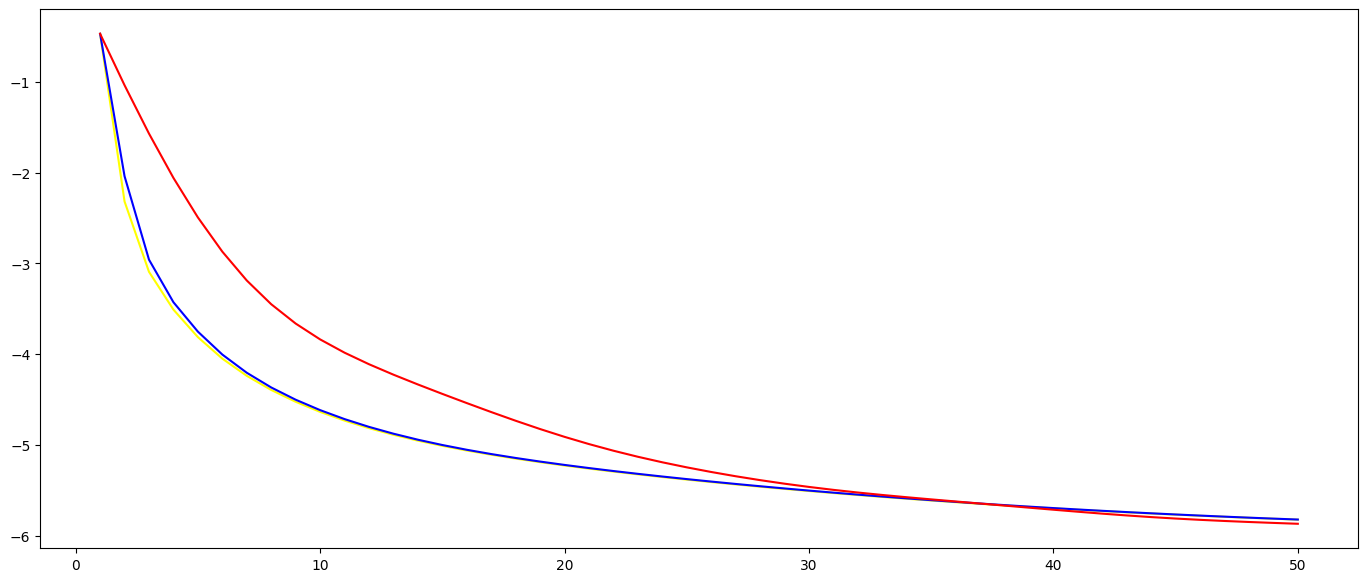

In [156]:
network = NeuralN([Layer_Dense(5, 1, 1)])
network.attribNN_r()
optimizer = Opti(SGD_Trad, network, gradtest, losstest)

network2 = network.mutNN(0,0)
optimizer2 = Opti(SGDM_Trad, network2, gradtest, losstest)

network3 = network.mutNN(0,0)
optimizer3 = Opti(ADAM_Trad, network3, gradtest, losstest)

n= 50
l = optimizer.train(n)
l2 = optimizer2.train(n)
l3 = optimizer3.train(n)
nb_epoch = [i+1 for i in range(n)]

from matplotlib import pyplot as plt
plt.figure(figsize=(17,7))
plt.plot(nb_epoch, l[0], color = 'yellow')
plt.plot(nb_epoch, l2[0], color = 'blue')
plt.plot(nb_epoch, l3[0], color = 'red')

Fonction de rosenbrock et rastrigin

In [291]:
import math as m
def rosenbrock(lst):
    x, y = lst[0], lst[1]
    return((1-x)**2 + 100*(y-(x)**2)**2)
def grosenbrock(lst):
    x, y = lst[0], lst[1]
    return [2*(x-1) +400*x*((x)**2 -y), 200*(y-(x)**2)]

def rastrigin(lst):
    return (10*len(lst) + np.sum([(lst[i]**2 - 10*np.cos(2*m.pi*lst[i])) for i in range(len(l))], axis = 0))
def grastrigin(lst):
    return [(2*lst[i]+ 20*m.pi*np.sin(2*m.pi*lst[i])) for i in range(len(lst))]


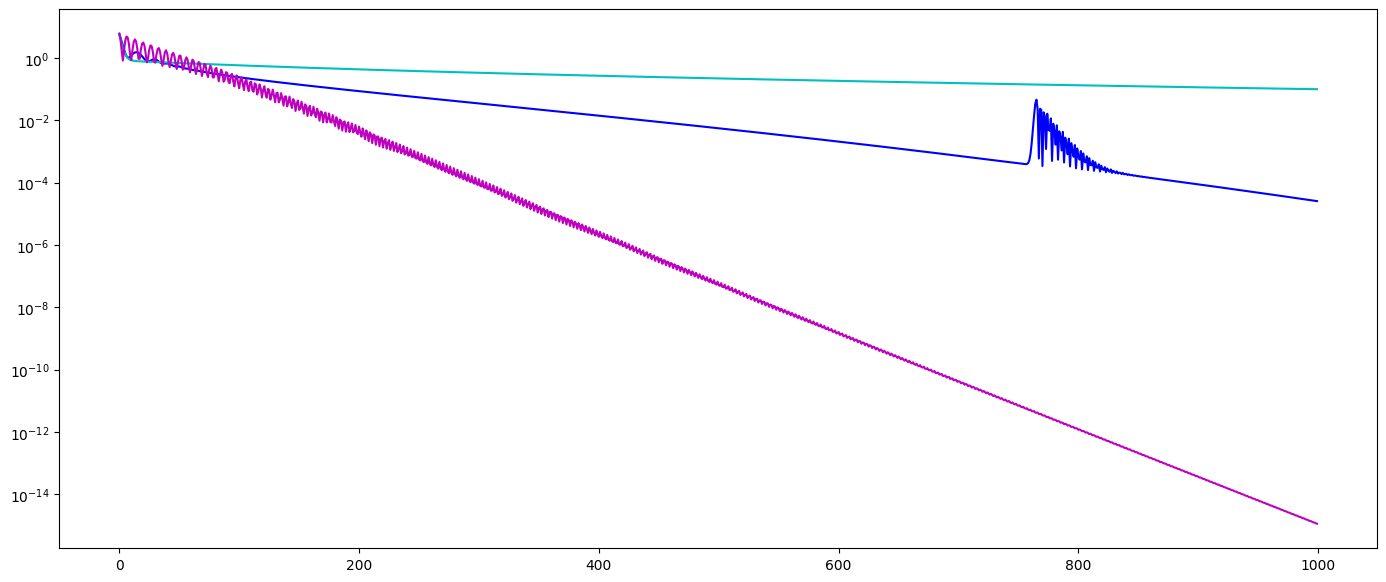

In [313]:
SGD_Slow = Algos(Sgd, [0.001], 0)
SGDM_Slow= Algos(SgdM3, [0.001, 0.04], 1)

Visu(NeuralN([Layer_Dense(1,1,1)]), grosenbrock, rosenbrock,[ADAM_Trad, SGD_Slow, SGDM_Slow], 1000, []).plt(True, False)
